# Tutorial 2: Simulating Interpolated Designs

In this tutorial we will learn how to simulate designs obtained from the SQuADDS Database. We will be using **Ansys HFSS** as the simulator backend in this tutorial.

**Warning: This tutorial will not run on Mac OS since Ansys HFSS is not available on Mac**

In [1]:
%load_ext autoreload
%autoreload 2

## Get Target Interpolated Design
Find the best geometries for your desired Hamiltonian parameters the same way as in [Tutorial 1](https://lfl-lab.github.io/SQuADDS/source/tutorials/Tutorial-1_Getting_Started_with_SQuADDS.html#Making-Systems-out-of-Circuit-QED-Elements):

In [2]:
from squadds import SQuADDS_DB

db = SQuADDS_DB()
db.select_system("qubit")
db.select_qubit("TransmonCross")
df = db.create_system_df()
# df

DotNet Core correctly loaded.


Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

In [ ]:
from squadds import Analyzer
analyzer = Analyzer(db)

target_params={"qubit_frequency_GHz": 4, "anharmonicity_MHz": -200}

results = analyzer.find_closest(target_params=target_params,
                                       num_top=3,
                                       metric="Euclidean",
                                       display=True)
results

In [ ]:
best_device = results.iloc[0]
best_device

In [ ]:
best_device_design = {'cavity_claw_options': {'coupler_type': 'CapNInterdigitalTee',
  'coupler_options': {'cap_distance': '50.9um',
   'cap_gap': '5um',
   'cap_gap_ground': '5.1um',
   'cap_width': '10um',
   'coupling_length': None,
   'coupling_space': None,
   'down_length': None,
   'finger_count': '5',
   'finger_length': '30um',
   'open_termination': None,
   'orientation': '-90',
   'prime_gap': '5.1um',
   'prime_width': '11.7um',
   'second_gap': '5.1um',
   'second_width': '11.7um'},
  'cpw_opts': {'left_options': {'fillet': '49.9um',
    'lead': {'end_straight': '50um',
     'start_jogged_extension': None,
     'start_straight': '100um'},
    'meander': {'asymmetry': None, 'spacing': '100um'},
    'pin_inputs': {'end_pin': {'component': 'claw', 'pin': 'readout'},
     'start_pin': {'component': 'cplr', 'pin': 'second_end'}},
    'total_length': '8700um',
    'trace_gap': '5.1um',
    'trace_width': '11.7um'}}},
 'qubit_options': {'aedt_hfss_capacitance': 0,
  'aedt_hfss_inductance': 9.686e-09,
  'aedt_q3d_capacitance': 0,
  'aedt_q3d_inductance': 1e-08,
  'chip': 'main',
  'connection_pads': {'readout': {'claw_cpw_length': '40um',
    'claw_cpw_width': '10um',
    'claw_gap': '5.1um',
    'claw_length': '190um',
    'claw_width': '15um',
    'connector_location': '90',
    'connector_type': '0',
    'ground_spacing': '4.1um'}},
  'cross_gap': '30um',
  'cross_length': '210um',
  'cross_width': '30um',
  'gds_cell_name': 'my_other_junction',
  'hfss_capacitance': 0,
  'hfss_inductance': 9.686e-09,
  'hfss_mesh_kw_jj': 7e-06,
  'hfss_resistance': 0,
  'layer': '1',
  'orientation': '-90',
  'pos_x': '-1500um',
  'pos_y': '1200um',
  'q3d_capacitance': 0,
  'q3d_inductance': '10nH',
  'q3d_mesh_kw_jj': 7e-06,
  'q3d_resistance': 0}}

In [ ]:
from squadds.components.coupled_systems import QubitCavity
import qiskit_metal as metal
from qiskit_metal import Dict, MetalGUI, designs, draw
from qiskit_metal.toolbox_metal import math_and_overrides

design = metal.designs.design_planar.DesignPlanar()
gui = metal.MetalGUI(design)
design.overwrite_enabled = True

qc = QubitCavity(design, "qubit_cavity", options=best_device_design)
gui.rebuild()
gui.autoscale()
gui.screenshot()

## Simulate the Target Design

Once you have the target design (in this case in Qiskit Metal format), you can then simulate it in whichever application you choose. However, we provide a native API to make it easier to get started with simulation on Ansys HFSS (support for AWS Palace will be provided hopefully in the near future!).   

We use the `AnsysSimulator` class to run simulations:

In [ ]:
from squadds import AnsysSimulator

The `AnsysSimulator` object takes the analyzer from before and the target "best device" that you want to simulate as parameters.

In [ ]:
ansys_simulator = AnsysSimulator(analyzer, best_device)

In [ ]:
best_device

We can view the geometry and simulation setup from the database entry for our best device as follows:

In [ ]:
best_device_geometry = best_device["design_options"]
best_device_geometry

Now, let's say we want to change some parameter in the design, for example, the `cross_length`, just for demonstration purposes.

In [ ]:
best_device_geometry["cross_length"] = '310um'
best_device_geometry

In [ ]:
best_device_sim_setup = best_device["setup"]
best_device_sim_setup

Then, we simulate our device with Ansys HFSS. In this case, we are simulating a TransmonCross object to get its corresponding capacitance matrix.

In [ ]:
ansys_results = ansys_simulator.simulate(best_device)
ansys_results

After the simulation is finished, we have the option to take screenshots of our design in the renderer and in Qiskit Metal to verify our geometry visually, as follows:

In [ ]:
ansys_simulator.get_renderer_screenshot()

In [ ]:
ansys_simulator.get_design_screenshot()

We can also analyze the simulated capacitance matrix results using the `get_xmon_info()` function, which returns the `qubit_anharmonicity_MHz` and  `qubit_frequency_GHz`.

In [ ]:
ansys_simulator.get_xmon_info(ansys_results)

### Extracting the data needed for contributing to the dataset

Suppose that we wanted to contribute this "new" design and simulation results to `SQuADDS_DB`.

We need to first, extract the correct data that will be neccessary for contributing the results.

First, we get the `design` dictionary:

In [ ]:
design_dict = ansys_results["design"]
design_dict

Then, we can get the `sim_options` dictionary:

In [ ]:
sim_options_dict = ansys_results["sim_options"]
sim_options_dict

And then the renderer options:

In [ ]:
renderer_options_dict = ansys_results["sim_options"]["renderer_options"]
renderer_options_dict

And finally, the `sim_results` dictionary:

In this particular simulation, all of our results have units of femtoFarads, so we can just add a global `units` key with value `fF`.

In [ ]:
sim_results_dict = ansys_results["sim_results"]
sim_results_dict.update({"units": "fF"})

We can then take the dictionaries that we have just created, and send them to a JSON file that we will use later on in Tutorial 3.

In [ ]:
final_dict = dict(
    sim_options = dict(
        renderer_options = renderer_options_dict,
        setup = sim_options_dict["setup"],
        simulator = sim_options_dict["simulator"]
    ),
    design = design_dict,
    sim_results = sim_results_dict
)
final_dict

Let's save the dictionaries to a JSON file so that we can use it later on in [Tutorial 3](https://lfl-lab.github.io/SQuADDS/source/tutorials/Tutorial-3_Contributing_to_SQuADDS.html#Contributing-to-an-existing-configuration), where go over this process in more detail.

In [ ]:
import json
with open("examples/single_xmon_lom.json", 'w') as outfile:
    json.dump(final_dict, outfile, indent=4)

## Simulating an Interpolated Qubit + Cavity device

This time, we look for a complete device, which includes a TransmonCross object coupled to a RouteMeander CPW and CoupledLineTee, as in Tutorial 1.

In [3]:
db.select_system(["qubit","cavity_claw"])
db.select_qubit("TransmonCross")
db.select_cavity_claw("RouteMeander")
db.select_resonator_type("quarter")
merged_df = db.create_system_df()
merged_df

Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

,claw_to_claw,claw_to_ground,cross_to_claw,cross_to_cross,cross_to_ground,ground_to_ground,units_qubit,PI_qubit,date_created_qubit,group_qubit,...,misc,uploader_cavity_claw,renderer_options_cavity_claw,setup_cavity_claw,simulator_cavity_claw,coupler_type,design_options_cavity_claw,design_tool_cavity_claw,resonator_type,design_options
0,94.97421,90.86585,3.73363,158.40783,158.40783,311.25590,fF,"Eli Levenson-Falk, PhD",2023-09-20-142547,LFL,...,None,Andre Kuo,None,"{'basis_order': 1, 'max_delta_f': 0.05, 'max_p...",Ansys HFSS,CLT,{'claw_opts': {'connection_pads': {'readout': ...,qiskit-metal,quarter,{'cavity_claw_options': {'coupler_type': 'CLT'...
1,94.97421,90.86585,3.73363,158.40783,158.40783,311.25590,fF,"Eli Levenson-Falk, PhD",2023-09-20-142547,LFL,...,None,Andre Kuo,None,"{'basis_order': 1, 'max_delta_f': 0.05, 'max_p...",Ansys HFSS,CLT,{'claw_opts': {'connection_pads': {'readout': ...,qiskit-metal,quarter,{'cavity_claw_options': {'coupler_type': 'CLT'...
2,94.97421,90.86585,3.73363,158.40783,158.40783,311.25590,fF,"Eli Levenson-Falk, PhD",2023-09-20-142547,LFL,...,None,Andre Kuo,None,"{'basis_order': 1, 'max_delta_f': 0.05, 'max_p...",Ansys HFSS,CLT,{'claw_opts': {'connection_pads': {'readout': ...,qiskit-metal,quarter,{'cavity_claw_options': {'coupler_type': 'CLT'...
3,94.97421,90.86585,3.73363,158.40783,158.40783,311.25590,fF,"Eli Levenson-Falk, PhD",2023-09-20-142547,LFL,...,None,Andre Kuo,None,"{'basis_order': 1, 'max_delta_f': 0.05, 'max_p...",Ansys HFSS,CLT,{'claw_opts': {'connection_pads': {'readout': ...,qiskit-metal,quarter,{'cavity_claw_options': {'coupler_type': 'CLT'...
4,94.97421,90.86585,3.73363,158.40783,158.40783,311.25590,fF,"Eli Levenson-Falk, PhD",2023-09-20-142547,LFL,...,None,Andre Kuo,None,"{'basis_order': 1, 'max_delta_f': 0.05, 'max_p...",Ansys HFSS,CLT,{'claw_opts': {'connection_pads': {'readout': ...,qiskit-metal,quarter,{'cavity_claw_options': {'coupler_type': 'CLT'...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18952,183.80802,168.04023,15.11184,214.45993,214.45993,454.60312,fF,"Eli Levenson-Falk, PhD",2023-09-20-142547,LFL,...,None,Andre Kuo,None,"{'basis_order': 1, 'max_delta_f': 0.05, 'max_p...",Ansys HFSS,CLT,{'claw_opts': {'connection_pads': {'readout': ...,qiskit-metal,quarter,{'cavity_claw_options': {'coupler_type': 'CLT'...
18953,183.80802,168.04023,15.11184,214.45993,214.45993,454.60312,fF,"Eli Levenson-Falk, PhD",2023-09-20-142547,LFL,...,,Andre Kuo,None,"{'basis_order': 1, 'max_delta_f': 0.05, 'max_p...",Ansys HFSS,CLT,{'claw_opts': {'connection_pads': {'readout': ...,qiskit-metal,quarter,{'cavity_claw_options': {'coupler_type': 'CLT'...
18954,183.80802,168.04023,15.11184,214.45993,214.45993,454.60312,fF,"Eli Levenson-Falk, PhD",2023-09-20-142547,LFL,...,,Andre Kuo,None,"{'basis_order': 1, 'max_delta_f': 0.05, 'max_p...",Ansys HFSS,CLT,{'claw_opts': {'connection_pads': {'readout': ...,qiskit-metal,quarter,{'cavity_claw_options': {'coupler_type': 'CLT'...
18955,183.80802,168.04023,15.11184,214.45993,214.45993,454.60312,fF,"Eli Levenson-Falk, PhD",2023-09-20-142547,LFL,...,,Andre Kuo,None,"{'basis_order': 1, 'max_delta_f': 0.05, 'max_p...",Ansys HFSS,CLT,{'claw_opts': {'connection_pads': {'readout': ...,qiskit-metal,quarter,{'cavity_claw_options': {'coupler_type': 'CLT'...


In [4]:
target_params = {
                "qubit_frequency_GHz": 4,
                "cavity_frequency_GHz": 6.2,
                "kappa_kHz": 120,
                "resonator_type":"quarter",
                "anharmonicity_MHz": -200,
                "g_MHz": 70}

In [5]:
from squadds import Analyzer

In [6]:
analyzer = Analyzer(db)

results = analyzer.find_closest(target_params=target_params,
                                       num_top=3,
                                       metric="Euclidean",
                                       display=True)
results

,claw_to_claw,claw_to_ground,cross_to_claw,cross_to_cross,cross_to_ground,ground_to_ground,units_qubit,PI_qubit,date_created_qubit,group_qubit,...,design_options_cavity_claw,design_tool_cavity_claw,resonator_type,design_options,EC,EJ,EJEC,qubit_frequency_GHz,anharmonicity_MHz,g_MHz
15374,113.99245,107.65111,5.75841,112.70740,112.70740,274.49373,fF,"Eli Levenson-Falk, PhD",2023-09-20-142547,LFL,...,{'claw_opts': {'connection_pads': {'readout': ...,qiskit-metal,quarter,{'cavity_claw_options': {'coupler_type': 'CLT'...,0.163509,12.278081,75.091150,3.836546,-182.146843,68.095121
2914,105.76081,99.80185,5.38260,100.41444,100.41444,251.82560,fF,"Eli Levenson-Falk, PhD",2023-10-25-153123,LFL,...,{'claw_opts': {'connection_pads': {'readout': ...,qiskit-metal,quarter,{'cavity_claw_options': {'coupler_type': 'CLT'...,0.183089,12.278081,67.060879,4.048670,-205.518797,70.226899
10676,109.80541,103.57639,5.68548,105.83609,105.83609,261.84982,fF,"Eli Levenson-Falk, PhD",2023-10-25-153123,LFL,...,{'claw_opts': {'connection_pads': {'readout': ...,qiskit-metal,quarter,{'cavity_claw_options': {'coupler_type': 'CLT'...,0.173690,12.278081,70.689450,3.948506,-194.262295,70.978895


In [7]:
best_device = results.iloc[0]
best_device

claw_to_claw                                                            113.99245
claw_to_ground                                                          107.65111
cross_to_claw                                                             5.75841
cross_to_cross                                                           112.7074
cross_to_ground                                                          112.7074
ground_to_ground                                                        274.49373
units_qubit                                                                    fF
PI_qubit                                                   Eli Levenson-Falk, PhD
date_created_qubit                                              2023-09-20-142547
group_qubit                                                                   LFL
institution_qubit                                                             USC
uploader_qubit                                                          Andre Kuo
renderer_options

In [8]:
best_device["design_options"]

{'cavity_claw_options': {'coupler_type': 'CLT',
  'coupler_options': {'cap_distance': None,
   'cap_gap': None,
   'cap_gap_ground': None,
   'cap_width': None,
   'coupling_length': '230um',
   'coupling_space': '7.9um',
   'down_length': '50um',
   'finger_count': None,
   'finger_length': None,
   'open_termination': False,
   'orientation': '-90',
   'prime_gap': '5.1um',
   'prime_width': '11.7um',
   'second_gap': '5.1um',
   'second_width': '11.7um'},
  'cpw_opts': {'left_options': {'fillet': '49.9um',
    'lead': {'end_straight': None,
     'start_jogged_extension': None,
     'start_straight': '50um'},
    'meander': {'asymmetry': '-115.0um', 'spacing': '100um'},
    'pin_inputs': {'end_pin': {'component': 'claw', 'pin': 'readout'},
     'start_pin': {'component': 'cplr', 'pin': 'second_end'}},
    'total_length': '3900um',
    'trace_gap': '5.1um',
    'trace_width': '11.7um'}}},
 'qubit_options': {'aedt_hfss_capacitance': 0,
  'aedt_hfss_inductance': 9.686e-09,
  'aedt_q3d_c

03:58PM 28s CRITICAL [_qt_message_handler]: line: 0, func: None(), file: None  WARNING: Layer-backing can not be explicitly controlled on 10.14 when built against the 10.14 SDK

03:58PM 29s CRITICAL [_qt_message_handler]: line: 0, func: None(), file: None  CRITICAL: <QNSWindow: 0x7fd1def8f130; contentView=<QNSView: 0x7fd1def8e9f0; QCocoaWindow(0x7fd1def8e8d0, window=QWidgetWindow(0x7fd1def8e450, name="MainWindowPlotWindow"))>> has active key-value observers (KVO)! These will stop working now that the window is recreated, and will result in exceptions when the observers are removed. Break in QCocoaWindow::recreateWindowIfNeeded to debug.

03:58PM 29s CRITICAL [_qt_message_handler]: line: 0, func: None(), file: None  CRITICAL: <QNSWindow: 0x7fd1defe0c90; contentView=<QNSView: 0x7fd1defe0550; QCocoaWindow(0x7fd1defe0430, window=QWidgetWindow(0x7fd1defdffd0, name="ElementsWindowWindow"))>> has active key-value observers (KVO)! These will stop working now that the window is recreated, and w

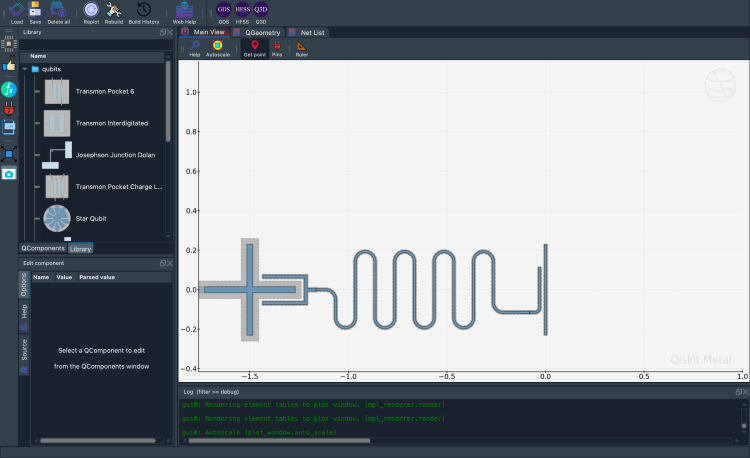

: 

In [9]:
from squadds.components.coupled_systems import QubitCavity
import qiskit_metal as metal
from qiskit_metal import Dict, MetalGUI, designs, draw
from qiskit_metal.toolbox_metal import math_and_overrides

design = metal.designs.design_planar.DesignPlanar()
gui = metal.MetalGUI(design)
design.overwrite_enabled = True

qc = QubitCavity(design, "qubit_cavity", options=best_device["design_options"]
)
gui.rebuild()
gui.autoscale()
gui.screenshot()

After getting our best result, we once again initialize our AnsysSimulator object, this time on our new system, and then simulate.

In [ ]:
ansys_simulator = AnsysSimulator(analyzer, best_device)

In [ ]:
ansys_results = ansys_simulator.simulate(best_device)
ansys_results

To extract the simulated Hamiltonian parameters, we look at the `sim_results` key in our `ansys_results` dictionary:

In [ ]:
hamiltonian_results = ansys_results["sim_results"]
hamiltonian_results

We can similarly get screenshots from Qiskit Metal and the Ansys renderer. Notice that the TransmonCross object and the cavity+claw object are rendered into the same design in Qiskit Metal. This is done purely out of convenience, and has no effect on the simulation results. This is shown in the renderer screenshots below, which show the TransmonCross and cavity+claw being rendered and simulated separately.

In [ ]:
ansys_simulator.get_design_screenshot()

In [ ]:
ansys_simulator.get_renderer_screenshot()

We can also plot our complete custom QubitCavity device in Qiskit Metal. 

In [ ]:
ansys_simulator.plot_device(ansys_results)

Finally, we can once again get relevant results dictionaries that will be useful if/when you decide to contribute your results to SQuADDS!

In [ ]:
design_dict = ansys_results["design"]
design_dict

In [ ]:
sim_options_dict = ansys_results["sim_options"]
sim_options_dict

In [ ]:
sim_results_dict = ansys_results["sim_results"]
sim_results_dict

We can once again update the units for our results. However, this time, the units are not all the same, so we must specify individual units.

In [ ]:
sim_results_dict.update({
    "cavity_frequency_GHz_unit": "GHz",
    "g_MHz_unit": "MHz",
    "anharmonicity_MHz_unit": "MHz",
    "kappa_kHz_unit": "kHz",
    "qubit_frequency_GHz_unit": "GHz",
})
sim_results_dict

## Simulating an Interdigitated Capacitor Device

We can now explore running a set of simulations sweeping over certain specified parameters for a device. In this case, we choose an interdigitated coupler device. Notice how the `total_length` parameter under `cpw_opts` in our `geometry_dict` is a `list` instead of a `String`. This lets our AnsysSimulator know that we wish to simulate this device [in this case] three total times, i.e. with the CPW `total_length=2000um`, with CPW `total_length = 4000um`, and with CPW `total_length = 7000um`. We can similarly specify sweeping over other parameters, using the same list syntax to denote which parameters should be swept over, and with respect to what dimensions, and the sweep will be done combinatorically with every combination of parameters specified.

In [ ]:
ncap_sweep_dict = {
    "coupling_type": "NCAP",
    "geometry_dict": {
        "claw_opts": {
            "connection_pads": {
                "readout": {
                    "connector_location": "90",
                    "connector_type": "0",
                    "claw_length": "50um",
                    "ground_spacing": "10um",
                    "claw_gap": "5.1um",
                    "claw_width": "7um",
                    "claw_cpw_width": "11.7um",
                    "claw_cpw_length": "0um"
                }
            },
            "cross_width": "30um",
            "cross_length": "300um",
            "cross_gap": "30um",
            "orientation": "-90",
            "pos_x": "-1000um"
        },
        "cpw_opts": {
            "fillet": "49.9um",
            "total_length": ["2000um", "4000um", "7000um"],
            "trace_width": "11.7um",
            "trace_gap": "5.1um",
            "lead": {
                "start_straight": "50um"
            },
            "pin_inputs": {
                "start_pin": {
                    "component": "cplr",
                    "pin": "second_end"
                },
                "end_pin": {
                    "component": "claw",
                    "pin": "readout"
                }
            }
        },
        "cplr_opts": {
            'prime_width': '11.7um',
            'prime_gap': '5.1um',
            'second_width': '11.7um',
            'second_gap': '5.1um',
            'cap_gap': '5um',
            'cap_width': '10um',
            'cap_gap_ground': '5.1um',
            'finger_length': '30um',
            'finger_count': '5',
            'cap_distance': '50.9um',
        }
    }
}

We can also specify a setup for the sweep, though a default high-accuracy one will be assigned. Currently, we only support eigenmode and LOM sweeps for TransmonCross, CavityClaw, and InterdigitatedCavityClaw objects, but more support will be added as necessary. (Note that in our example setup, the `max_passes` parameter is set to `1`; this is for the sake of speed/demonstration only, it is HIGHLY recommended to run more than 1 pass for your more important simulations)

In [ ]:
example_eigenmode_setup = {
    "setup": {
        'basis_order': 1,
        'max_delta_f': 0.05,
        'max_passes': 1,
        'min_converged': 1,
        'min_converged_passes': 2,
        'min_freq_ghz': 1,
        'min_passes': 1,
        'n_modes': 1,
        'name': 'default_eigenmode_setup',
        'pct_refinement': 30,
        'reuse_selected_design': True,
        'reuse_setup': True,
        'vars': {'Cj': '0fF', 'Lj': '0nH'}
    }
}

Finally, call `ansys_simulator.sweep()` on our sweep dictionary, and include your `setup` dictionary if desired.

In [ ]:
ansys_simulator.sweep(ncap_sweep_dict, emode_setup=example_eigenmode_setup)

The sweeper code saves the resuts of every iteration of the sweep into a `json` file, which can be found in the same folder as this Tutorial.

## License

<div style='width: 100%; background-color:#3cb1c2;color:#324344;padding-left: 10px; padding-bottom: 10px; padding-right: 10px; padding-top: 5px'>
    <h3>This code is a part of SQuADDS</h3>
    <p>Developed by Sadman Ahmed Shanto</p>
    <p>&copy; Copyright Sadman Ahmed Shanto & Eli Levenson-Falk 2023.</p>
    <p>This code is licensed under the MIT License. You may<br> obtain a copy of this license in the LICENSE.txt file in the root directory<br> of this source tree.</p>
    <p>Any modifications or derivative works of this code must retain this<br>copyright notice, and modified files need to carry a notice indicating<br>that they have been altered from the originals.</p>
</div>